In [1]:
using DifferentialEquations, Plots, SpecialFunctions, DataStructures, BenchmarkTools
gr();

include("Lab.jl")
include("Sim.jl")
include("Forces.jl")

In [2]:
@show trap_a_param(UWTrap);
@show trap_q_param(UWTrap);

0.022481978498952282

trap_a_param(UWTrap) = 0.00044963956997904557
trap_q_param(UWTrap) = 0.022481978498952282


In [3]:
N = 4;
atoms = [Barium for i=1:N];
γ = 1e-30
ω = 1e-26

config = SimInfo(1. / UWTrap.ω₀ / 15euler, UWTrap, atoms, N, [atom.mass for atom in atoms], [atom.charge for atom in atoms]);
@show config.dt;

config.dt = 2.1446824734182845e-10


In [5]:
r₀ = zeros(3,N)
ṙ₀ = zeros(3,N)
d = eq_distance(config.N, config.trap)
@show d
pos = (0:config.N-1) * d
r₀[3, :] = pos - ((config.N-1)/2)*d
cooling_limit = h * Barium.natural_line_width / (4π*kB)
vel = randn(3,config.N)
for i=1:config.N
    normalize!(vel[:,i])
    vel[:,i] .*= √(3 * h * config.atoms[i].natural_line_width / (4π*config.m[i]))
end
ṙ₀[:,:,1] = vel * 1
T₀ = calcTemp(ṙ₀, config)
@show cooling_limit;
@show T₀;
[r₀,ṙ₀]

d = 8.238649396290754e-6


2-element Array{Array{Float64,2},1}:
 [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -1.2358e-5 -4.11932e-6 4.11932e-6 1.2358e-5]                                         
 [-0.65044 -0.206922 -0.0711684 0.130225; 0.0751268 0.397988 0.150816 -0.0240036; 0.299974 -0.336161 -0.327865 -0.521817]

cooling_limit = 0.0003599433496658513
T₀ = 0.0017315639306001195


In [44]:
# forces


In [45]:
config.trap

IonTrap(1.1435397259066847e8, 1000.0, 10.0, 0.00093, 0.000793, 0.00284, [1.0 0.0 … -0.0 -0.0; 0.0 1.0 … -1.0 -0.0; 0.0 0.0 … -0.0 -1.0])

In [46]:
function dynamics!(r̈, ṙ, r, p, t)
    fill!(r̈, 0.)
    #f = zeros(3, config.N) # force
    #Damping!(f,ṙ,t,config)
    Coulomb!(r̈, r, t, config)
    #Harmonic!(f, r, t, config)
    E_Field!(r̈, r, t, config)
    
    #Laser_Cooling!(r̈, ṙ, t, config)
    
    for i=1:config.N # force to acceleration
        r̈[:,i] ./= config.m[i]
    end
    return r̈
end;

In [47]:
#dynamics(z₀, 1, 1e-7)

In [57]:
nframes = 100
frame_freq = 500
#tspan = (0., frames*timestep)
prob = SecondOrderODEProblem{true}(dynamics!, ṙ₀, r₀, (0., 1.));
times = zeros(nframes)
temp = zeros(nframes)
pos = zeros(3,config.N, nframes)
vel = zeros(3,config.N, nframes);

In [58]:
integrator = init(prob,VelocityVerlet(); dt=config.dt, dense=false, save_everystep=false)

t: 0.0
u: ([0.134388 0.175022 0.123178 0.20346; -0.331102 -0.174273 -0.205278 0.104577; -0.0625959 0.395649 -0.157421 -0.056804], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; -1.2358e-5 -4.11932e-6 4.11932e-6 1.2358e-5])

In [59]:
ṙ, r = integrator.u.x
times[1] = integrator.t
pos[:,:,1] = r
vel[:,:,1] = ṙ

for i=2:nframes

    for s=1:frame_freq
        step!(integrator)
    end
    
    ṙ, r = integrator.u.x
    times[i] = integrator.t
    temp[i] = calcTemp(ṙ, config)
    pos[:,:,i] = r
    vel[:,:,i] = ṙ
    
    if i % 10 == 0
        println("$i / $nframes done")
    end
end

10 / 100 done
20 / 100 done
30 / 100 done
40 / 100 done
50 / 100 done
60 / 100 done
70 / 100 done
80 / 100 done
90 / 100 done
100 / 100 done


In [52]:
pos

3×4×100 Array{Float64,3}:
[:, :, 1] =
  0.0         0.0         0.0         0.0      
  0.0         0.0         0.0         0.0      
 -1.2358e-5  -4.11932e-6  4.11932e-6  1.2358e-5

[:, :, 2] =
  1.21506e-8   1.58715e-8   1.11056e-8  1.84445e-8
 -3.87546e-8  -2.02931e-8  -2.41149e-8  1.23667e-8
 -1.23572e-5  -4.05822e-6   4.08338e-6  1.23447e-5

[:, :, 3] =
  2.10845e-8   2.78065e-8   1.90901e-8  3.22776e-8
 -5.69596e-8  -2.92614e-8  -3.59212e-8  1.88538e-8
 -1.23399e-5  -3.96601e-6   4.01413e-6  1.23169e-5

...

[:, :, 98] =
  3.47775e-8   2.34264e-8   3.38234e-8  2.504e-8  
 -4.70968e-8  -1.54568e-8  -3.85719e-9  9.67506e-9
 -1.21429e-5  -3.77727e-6   3.8747e-6   1.21281e-5

[:, :, 99] =
  3.11867e-8   2.70738e-8  3.34003e-8  2.78027e-8
 -2.67135e-8  -1.2525e-8   1.81464e-8  2.93908e-8
 -1.22054e-5  -3.89103e-6  3.98447e-6  1.21988e-5

[:, :, 100] =
  1.93483e-8   2.30186e-8  2.41975e-8  2.28113e-8
  8.6368e-9   -3.26654e-9  3.22212e-8  3.48268e-8
 -1.22556e-5  -3.99129e-6  4.07424e

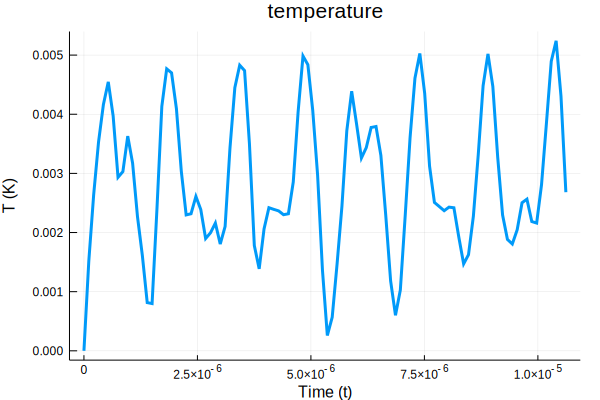

In [53]:
plot(times, temp, linewidth=3,title="temperature",
     xaxis="Time (t)",yaxis="T (K)", legend=false)

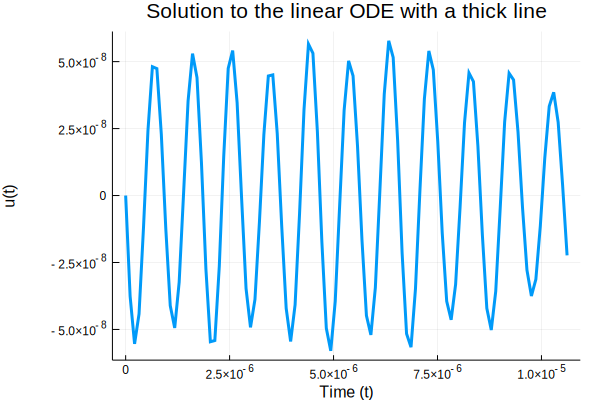

In [38]:
plot(times, pos[2,2,:], linewidth=3,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t)",label="pos", legend=false)

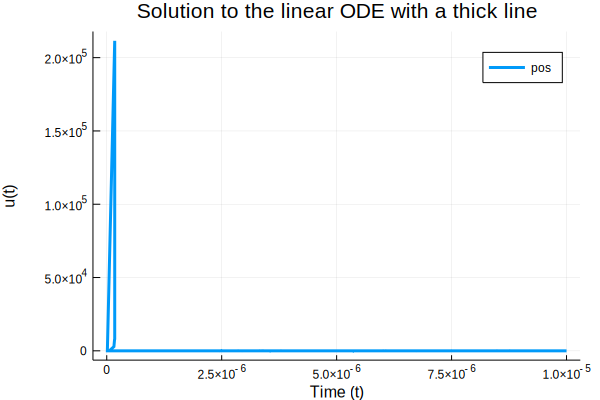

In [119]:
plot(time, temp,linewidth=3,title="Solution to the linear ODE with a thick line",
     xaxis="Time (t)",yaxis="u(t)",label="pos") # legend=false
#plot!(t, [x[1,1,1] for x in sol(t)],linewidth=3,title="Solution to the linear ODE with a thick line",
#     xaxis="Time (t)",yaxis="u(t) (in μm)",label="vel")